In [2]:
import numpy as np
import matplotlib as mpl

mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.labelleft'] = False

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.fft import fft, ifft, fftfreq
from IPython import display

%matplotlib inline

In [3]:
def ch_on_grid(f_min=-4, f_max=4):
    x = np.stack(np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01)), -1)
    t = np.arctan2(x[..., 1], x[..., 0])
    freq = 1j * np.arange(f_min, f_max+1)
    Y = np.exp(freq[:, None, None] * t[None, ...])
    return Y

Text(0.5, 0.98, 'Circular Harmonics, $l=[-4, \\ldots, 4]$')

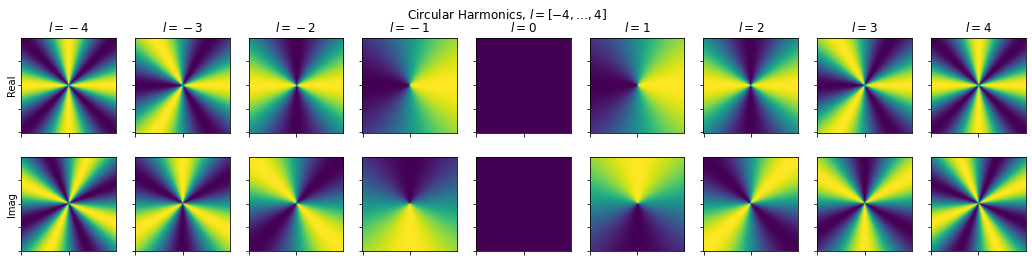

In [4]:
Y = ch_on_grid()

fig, ax = plt.subplots(2, Y.shape[0], figsize=(18, 4))
ax[0, 0].set_ylabel('Real')
ax[1, 0].set_ylabel('Imag')
for i in range(Y.shape[0]):
    ax[0, i].imshow(np.real(Y[i]), origin='lower')
    ax[1, i].imshow(np.imag(Y[i]), origin='lower')
    ax[0, i].set_title(rf'$l = {i-4}$')

fig.suptitle(r'Circular Harmonics, $l=[-4, \ldots, 4]$')

In [5]:
def ch2_on_grid(f_min=-4, f_max=4):
    x = np.stack(np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01)), -1)
    rho = np.linalg.norm(x, axis=-1)
    t = np.arctan2(x[..., 1], x[..., 0])
    freq = 1j * np.arange(f_min, f_max+1)
    Y = np.exp(-rho ** 2) * np.exp(freq[:, None, None] * t[None, ...])
    return Y

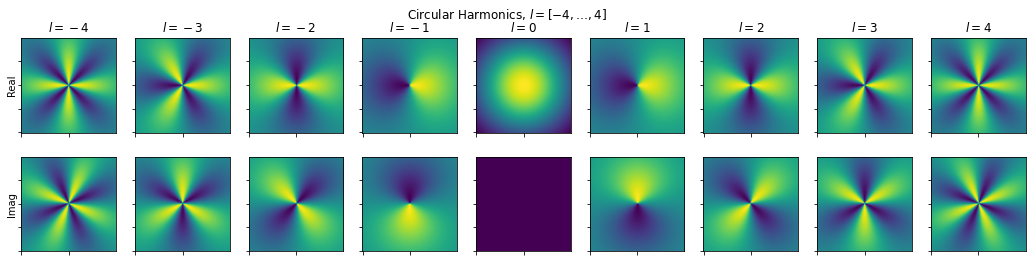

In [6]:
f_min = -4
f_max = 4
Y = ch2_on_grid()

fig, ax = plt.subplots(2, Y.shape[0], figsize=(18, 4))
ax[0, 0].set_ylabel('Real')
ax[1, 0].set_ylabel('Imag')
for i in range(Y.shape[0]):
    ax[0, i].imshow(np.real(Y[i]), origin='lower')
    ax[1, i].imshow(np.imag(Y[i]), origin='lower')
    ax[0, i].set_title(rf'$l = {i+f_min}$')

fig.suptitle(rf'Circular Harmonics, $l=[{f_min}, \ldots, {f_max}]$')
# fig.savefig('circular_harmonics.png', dpi=300, bbox_inches='tight')

In [13]:
def pm_polar(ax, t, x, colors):
    """Polar plot with different colors for positive and negative values"""
    ax.plot(t[x > 0], x[x > 0], colors[0])
    ax.plot(t[x <= 0], -x[x <= 0], colors[1])

In [14]:
N = 1024
t = np.linspace(0, 2*np.pi, N)

colors = ['#ef8a62', '#67a9cf']
bands = np.arange(0, 6)
basis = np.exp(1j * bands[:, None] * t[None, :])

cos_basis = np.cos(bands[:, None] * t[None, :])
sin_basis = np.sin(bands[:, None] * t[None, :]) 

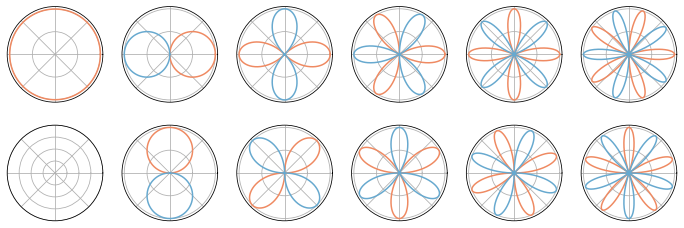

In [15]:
fig, ax = plt.subplots(2, len(bands), subplot_kw={'projection': 'polar'}, figsize=(12, 4))
for i, bi in enumerate(bands):
    if basis[i].real.nonzero()[0].any():
        pm_polar(ax[0, i], t, basis[i].real, colors)
    if basis[i].imag.nonzero()[0].any():
        pm_polar(ax[1, i], t, basis[i].imag, colors)
# plt.show()

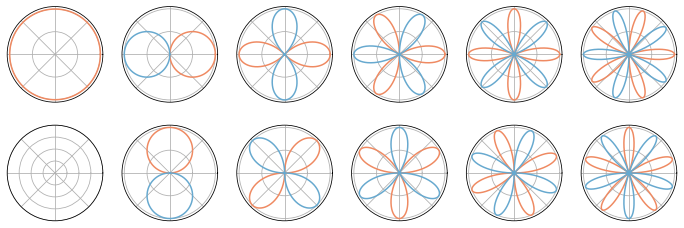

In [16]:
fig, ax = plt.subplots(2, len(bands), subplot_kw={'projection': 'polar'}, figsize=(12, 4))
for i, bi in enumerate(bands):
    if cos_basis[i].nonzero()[0].any():
        pm_polar(ax[0, i], t, cos_basis[i], colors)
    if sin_basis[i].nonzero()[0].any():
        pm_polar(ax[1, i], t, sin_basis[i], colors)
# plt.show()

## Signal Harmonics

In [17]:
colors = ['#ef8a62', '#67a9cf']
N = 1024
B = 7
t = np.linspace(0, 2*np.pi, N)
bands = np.arange(B)
b = np.exp(1j * bands[:, None] * t[None, :])

x = np.zeros_like(t)
x[0:N//2+0] = 1/(N//2)
# x[512:513] = 1.

xf = fftfreq(1024, 1. / 1024)[:1024//2]
X = fft(x)

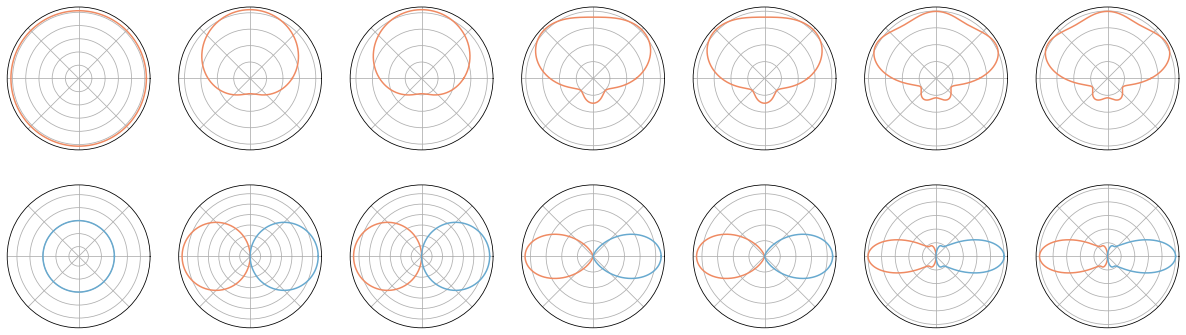

In [18]:
# Manually compute the harmonics

fig, ax = plt.subplots(2, len(bands), subplot_kw={'projection': 'polar'}, figsize=(21, 6))
for i, bi in enumerate(bands):
    # w = b[:bi+1, 100:N//2+100].conj().sum(1, keepdims=True)

    # Solution to the integral
    k = np.arange(bi+1)[:, None]
    k[0] = 1
    w = N / (2 * np.pi * k) * (
        np.exp(-1j * 2 * np.pi * (N//2) * k / N + 1j * np.pi/2)
        - np.exp(1j * np.pi/2))
    w[0] = N // 2

#     w = b[:bi+1, [512]]
    ix = np.sum(b[:bi+1] * w, axis=0)
    pm_polar(ax[0, i], t, ix.real, colors)
    pm_polar(ax[1, i], t, ix.imag, colors)
# plt.show()

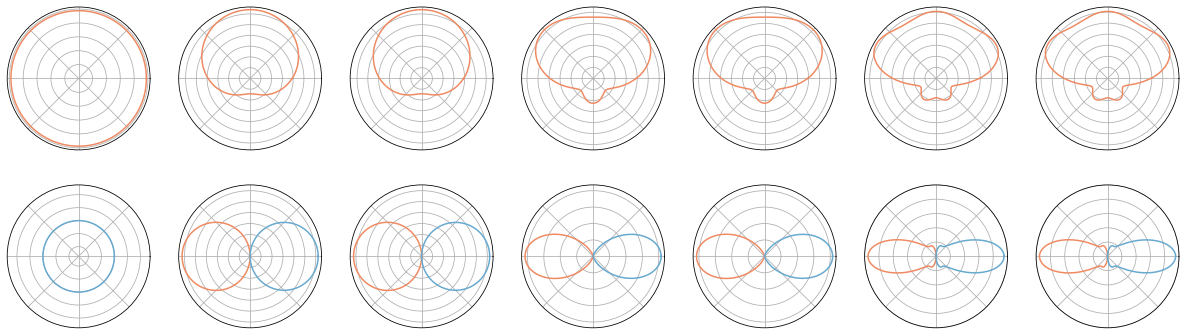

In [19]:
# Use FFT-IFFT for the harmonics

fig, ax = plt.subplots(2, len(bands), subplot_kw={'projection': 'polar'}, figsize=(21, 6))
for i, bi in enumerate(bands):
    ix = ifft(X[:bi+1], n=1024)

    pm_polar(ax[0, i], t, ix.real, colors)
    pm_polar(ax[1, i], t, ix.imag, colors)
# plt.show()

In [20]:
def init_ax():
    for i, bi in enumerate(bands):
        ax[0, i].clear()
        ax[1, i].clear()

def update(frame):
    init_ax()
    for i, bi in enumerate(bands):
        bb = b[bi, frame]
        if bb.real.nonzero()[0].any():
            pm_polar(ax[0, i], t, bb.real, colors)
        if bb.imag.nonzero()[0].any():
            pm_polar(ax[1, i], t, bb.imag, colors)
            
def update_real(frame):
    init_ax()
    for i, bi in enumerate(bands):
        cb = c[bi, frame]
        sb = s[bi, frame]
        if cb.nonzero()[0].any():
            pm_polar(ax[0, i], t, cb, colors)
        if sb.nonzero()[0].any():
            pm_polar(ax[1, i], t, sb, colors)

In [21]:
N = 1024
B = 7
t = np.linspace(-6*np.pi, 6*np.pi, N)
colors = ['#ef8a62', '#67a9cf']
bands = np.arange(0, B)

frames = np.stack([
    np.concatenate([np.full(20, 1.0), np.linspace(1.0, bi, 100),
                    np.full(20, bi), np.linspace(bi, 1.0, 100),
                    np.full(20, 1.0)])
    for bi in bands], 0)

b = np.exp(1j * frames[..., None] *  t[None, None, :])
# c = np.cos(frames[..., None] *  t[None, None, :])
# s = np.sin(frames[..., None] *  t[None, None, :])

In [22]:
fig, ax = plt.subplots(2, len(bands), subplot_kw={'projection': 'polar'}, figsize=(12, 4))

init_ax()

ani = FuncAnimation(
    fig, update, frames=np.arange(frames.shape[1]), interval=100)
video = ani.to_html5_video()
  
# embedding for the video
html = display.HTML(video)
  
# draw the animation
display.display(html)
plt.close()